In [167]:
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt

In [168]:
# plotting style, overrides ide themes
plt.style.use("default")

# general constants
AVOGADRO = 6.02*math.pow(10, 23)  # atoms/mol
JSPLANCK = 6.626*math.pow(10, -34)  # J*s
CHARGE_ELECTRON = 1.602*math.pow(10,-19)  # C or A*s
WEIGHT_ATOMIC_CO2 = 12  # g/mol
MASS_ELECTRON = 9.109*math.pow(10, -31)  # kg
DENSITY_GRAPHITE = 2.25  # g/cm^3

# specific constants
TUBE_DIAMETER = 65  # mm
N = 1  # order of difraction
UNCERTAINTY_RULER = 0.05  # mm
UNCERTAINTY_MASS_ELECTRON = 0.05*MASS_ELECTRON  # 0.5% error -> kg
UNCERTAINTY_VOLTAGE = 0.1  # kV

In [169]:
# Load in Data
in_pickle = open('lab03/data/readings.pkl', 'rb')
# data (ndarray) = [[sample_voltage,inner_diameter,outer_diameter],..]
main_data = pickle.load(in_pickle)

# enums for indexing into the main_data columns
SAMPLE_VOLTAGES = 0
INNER_DIAMETER = 1
OUTER_DIAMETER = 2
# for average_data
AVERAGE_DIAMETER = 1
AVERAGE_RADIUS = 2

In [170]:
# convert to SI units
# mm -> m
conversionFactor = 1/(10*100)
# update data
for i in [INNER_DIAMETER, OUTER_DIAMETER]:
    main_data[:,i] *= conversionFactor


# update constants and measurements
UNCERTAINTY_RULER *= conversionFactor
TUBE_DIAMETER *= conversionFactor
DBWAVELENGTH *= conversionFactor

# generate average data
average_data = np.ndarray(shape=main_data.shape)
average_data[:,SAMPLE_VOLTAGES] = np.copy(main_data[:,SAMPLE_VOLTAGES])
average_data[:,AVERAGE_DIAMETER] = (main_data[:,INNER_DIAMETER] + main_data[:,OUTER_DIAMETER])/2
average_data[:,AVERAGE_RADIUS] = average_data[:,AVERAGE_DIAMETER]/2

# kV -> V
main_data[:,SAMPLE_VOLTAGES] *= 1000
average_data[:,SAMPLE_VOLTAGES] *= 1000
UNCERTAINTY_VOLTAGE *= 1000  # 1kV = 1000V

In [171]:
def calc_average_diameter_uncert(uncertA, uncertB):
    delta2 = 1*math.pow(uncertA, 2) + 1*math.pow(uncertB, 2)
    return math.pow(delta2,1/2)
UNCERTAINTY_AVG_DIAMETER = calc_average_diameter_uncert(UNCERTAINTY_RULER, UNCERTAINTY_RULER)
UNCERTAINTY_AVG_RADIUS = UNCERTAINTY_AVG_DIAMETER/2

In [172]:
def calc_wavelength(Ua, e=CHARGE_ELECTRON, m=MASS_ELECTRON, h=JSPLANCK):
    root = math.pow(2*m*e*Ua, 1/2)
    return h/root

def calc_wavelength_uncert(Ua, dm=UNCERTAINTY_MASS_ELECTRON, dUa=UNCERTAINTY_VOLTAGE,h=JSPLANCK, e=CHARGE_ELECTRON, m=MASS_ELECTRON):
    delta2 = pow(abs(-h*e*Ua*pow(2*m*e*Ua,-3/2)) * dm, 2) + pow(abs(-h*e*m*pow(2*m*e*Ua,-3/2)) * dUa, 2)
    return math.pow(delta2,1/2)

rows = average_data[:,SAMPLE_VOLTAGES].shape[0]
wavelengths = np.ndarray(shape=(rows,))
wavelength_uncert = np.ndarray(shape=(rows,))
for i in range(rows):
    wavelengths[i] = calc_wavelength(average_data[:,SAMPLE_VOLTAGES][i])
    wavelength_uncert[i] = calc_wavelength_uncert(average_data[:,SAMPLE_VOLTAGES][i])

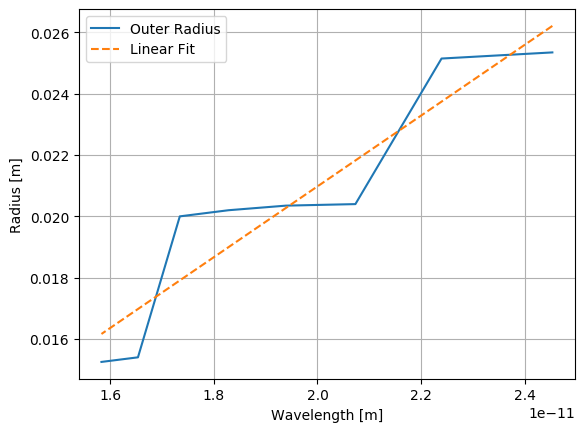

In [173]:
# Outer Radius vs Wavelength
plt.plot(wavelengths, main_data[:,OUTER_DIAMETER]/2, label="Outer Radius")
plt.xlabel("Wavelength [m]")
plt.ylabel("Radius [m]")
plt.grid(True)

# linear fit: https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
outerFitDump = np.polyfit(wavelengths, main_data[:,OUTER_DIAMETER]/2, deg=1, full=True)
outerFit = np.poly1d(outerFitDump[0])
plt.plot(wavelengths, outerFit(wavelengths), "--", label="Linear Fit")

plt.legend()
plt.savefig(fname="lab03/exports/outer-radius_wavelength.png", quality=95, dpi=100)
plt.show()

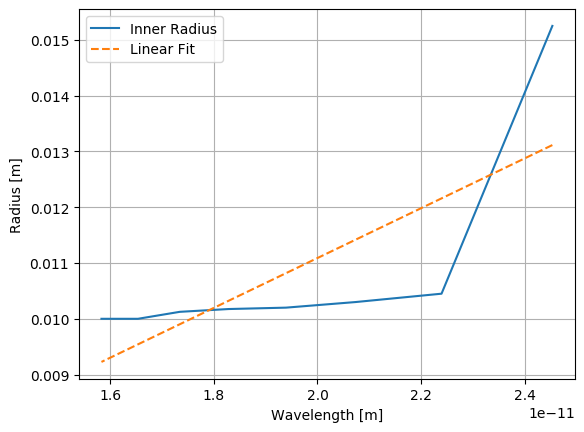

In [174]:
# Inner Radius vs Wavelength
plt.plot(wavelengths, main_data[:,INNER_DIAMETER]/2, label="Inner Radius")
plt.xlabel("Wavelength [m]")
plt.ylabel("Radius [m]")
plt.grid(True)

# linear fit: https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
innerFitDump = np.polyfit(wavelengths, main_data[:,INNER_DIAMETER]/2, deg=1, full=True)
innerFit = np.poly1d(innerFitDump[0])
plt.plot(wavelengths, innerFit(wavelengths), "--", label="Linear Fit")

plt.legend()
plt.savefig(fname="lab03/exports/inner-radius_wavelength.png", quality=95, dpi=100)
plt.show()

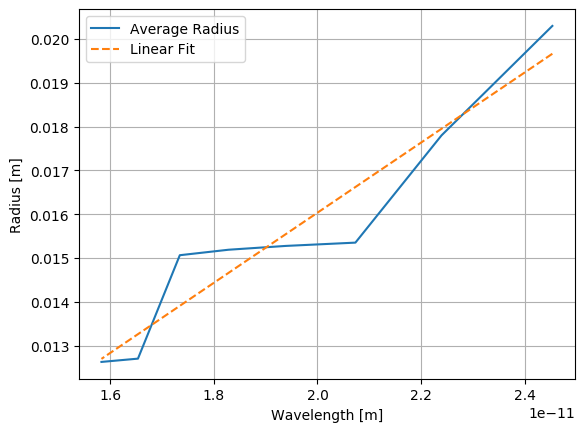

In [175]:
# Average Radius vs Wavelength
plt.plot(wavelengths, average_data[:,AVERAGE_RADIUS], label="Average Radius")
plt.xlabel("Wavelength [m]")  # assuming meters because values used to calculate wavelength are in SI units
plt.ylabel("Radius [m]")
plt.grid(True)

# linear fit: https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
avgRadiusDump = np.polyfit(wavelengths, average_data[:,AVERAGE_RADIUS], deg=1, full=True)
avgRadiusFit = np.poly1d(avgRadiusDump[0])
plt.plot(wavelengths, avgRadiusFit(wavelengths), "--", label="Linear Fit")
plt.legend()
plt.savefig(fname="lab03/exports/average-radius_wavelength.png", quality=95, dpi=100)
plt.show()

In [176]:
# calc d
def calc_plane_seperation(slope, n=N, R=(TUBE_DIAMETER/2)):
    return 2*R*slope*N

def calc_plane_seperation_uncert(ds, R=TUBE_DIAMETER/2, n=N):
    return math.pow(math.pow(abs(2*R*N)* ds, 2), 1/2)

In [177]:
# Finding the distance between planes (d)
    # The slope wavelength/avgR is the line of fit above
avgRSlope = avgRadiusDump[0][0]  # first term is the inverse slope
UNCERTAINTY_AVGRSLOPE = avgRadiusDump[1]  # very small

dPlaneDistance = calc_plane_seperation(pow(avgRSlope, -1))
ds = math.pow(avgRSlope, -2) * UNCERTAINTY_AVGRSLOPE
UNCERTAINTY_PLANE_DISTANCE = calc_plane_seperation_uncert(ds)  # basically nothing
print("Plane seperation (d): {} m +- {} m".format(dPlaneDistance, UNCERTAINTY_PLANE_DISTANCE))


Plane seperation (d): 8.11009209796109e-11 m +- 4.097365850080791e-25 m


In [178]:
# d100 - inner ring
innerSlope = innerFitDump[0][0]  # first term is the inverse slope
UNCERTAINTY_INNERSLOPE = innerFitDump[1]  # very small
d100 = calc_plane_seperation(pow(innerSlope, -1))
dInnerSlope = math.pow(innerSlope, -2) * UNCERTAINTY_INNERSLOPE
UNCERTAINTY_D100 = calc_plane_seperation_uncert(dInnerSlope)
print("Plane seperation (d100): {} m +- {} m".format(d100, UNCERTAINTY_D100))

Plane seperation (d100): 1.4541182046198927e-10 m +- 3.2491098604926985e-24 m


In [179]:
# d110 - outer radius
outerSlope = outerFitDump[0][0]  # first term is the inverse slope
UNCERTAINTY_OUTERSLOPE = outerFitDump[1]  # very small
d110 = calc_plane_seperation(pow(outerSlope, -1))
dOuterSlope = math.pow(outerSlope, -2) * UNCERTAINTY_OUTERSLOPE
UNCERTAINTY_D110 = calc_plane_seperation_uncert(dOuterSlope)
print("Plane seperation (d110): {} m +- {} m".format(d110, UNCERTAINTY_D110))

Plane seperation (d110): 5.623154498433665e-11 m +- 6.761534108319173e-25 m


In [180]:
# alternative method for finding d100
rows = average_data[:,SAMPLE_VOLTAGES].shape[0]
chi = np.ndarray(shape=(rows,))
innerR = main_data[:,INNER_DIAMETER]/2
d100b = np.copy(term1)

def calc_term1(Ua, R=TUBE_DIAMETER/2, h=JSPLANCK, m=MASS_ELECTRON, e=CHARGE_ELECTRON):
    numerator = 2*R*h
    denominator = math.pow(2*m*e*Ua, 1/2)
    return numerator/denominator

for i in range(rows):
    term1[i] = calc_term1(Ua=average_data[:,SAMPLE_VOLTAGES][i])
    d100b[i] = term1[i]/innerR[i]

avg_d100 = sum(d100b)/d100b.shape[0]
# angstrom
avg_d100A = avg_d100*math.pow(10,10)


In [181]:
# alternative method for finding d110
rows = average_data[:,SAMPLE_VOLTAGES].shape[0]
outerR = main_data[:,OUTER_DIAMETER]/2
d110b = np.copy(term1)

for i in range(rows):
    # same term1[i] from d100b, only r changes
    d110b[i] = term1[i]/outerR[i] 
 
avg_d110 = sum(d110b)/d110b.shape[0]
#angstrom
avg_d110A = avg_d110*math.pow(10,10)

In [182]:
# uncertainty of dkhl
def calc_dkhl_uncert(set_d):
    max_ = max(set_d)
    min_ = min(set_d)
    dx = (max_ - min_)/2
    cardinality = len(set_d)
    dx_avg = dx/cardinality
    return dx_avg

UNCERTAINTY_D100B = calc_dkhl_uncert(d100b)
UNCERTAINTY_D110B = calc_dkhl_uncert(d110b)

# in angstrom
UNCERTAINTY_D100BA = UNCERTAINTY_D100B * 10**10
UNCERTAINTY_D110BA = UNCERTAINTY_D110B * 10**10


In [185]:
# finding x
x1 = avg_d100A/1.5
x2 = avg_d110A/(0.5*math.pow(3, 1/2))

dx1 = UNCERTAINTY_D100BA/1.5
dx2 = UNCERTAINTY_D110BA/(0.5*math.pow(3, 1/2))

dx = calc_dkhl_uncert([x1, x2])
print((x1+x2)/2, dx)

0.7521059213440402 0.014291392156280308
